In [2]:
import numpy as np
from numba import njit

In [147]:
from scipy.linalg import solve


def ls(x, f, df, dx, a=1/3, b=1/2):
    t = 1
    fx = f(x)
    m = np.dot(df, dx)
    while fx - f(x + t * dx) > t * a * m:
        t = b * t
    return t

def bhhh(f, fp, x, clamp=None, tol=1e-9, maxiter=1000):
    for _ in range(maxiter):
        dfn = fp(x)

        # expected outer product of scores
        ddf = np.zeros((dfn.shape[1], dfn.shape[1]))
        for df in dfn:
            ddf += np.outer(df, df) / dfn.shape[0]

        df = dfn.mean(axis=0)
        dx = solve(ddf, df, assume_a='pos')

        t = ls(x, f, df, dx)
        x = x + t * dx

        if clamp is not None:
            x = clamp(x)

        if np.linalg.norm(t * dx) < tol:
            break
    
    return x

In [148]:
from scipy.stats import norm

x = np.random.normal(size=3000, loc=-5, scale=np.sqrt(30))

@njit
def l(theta):
    mu, sig2 = theta
    n = len(x)
    return - n / 2 * np.log(2 * np.pi) - n / 2 * np.log(sig2) - 1 / (2 * sig2) * ((x - mu) ** 2).sum()
    return np.log(norm.pdf(x, loc=mu, scale=np.sqrt(sig2))).sum()

@njit
def scores(theta):
    mu, sig2 = theta
    dmu  = (1 / sig2) * (x - mu)
    dsig = - 1 / (2 * sig2) + 1 / (sig2 ** 2) * (x - mu) ** 2
    return np.stack((dmu, dsig)).T

In [149]:
bhhh(l, scores, np.asarray([2, 2]))

array([-4.61347147, 31.95809187])

In [150]:
def sim(x, p, q, n):
    k = max(p, q)
    w, a, b = x[0], x[1 : p + 1], x[p + 1 :]

    sq = np.random.normal(size=n + 30) ** 2
    h = np.zeros_like(sq)

    for t in range(k, len(h)):
        h[t] = w + np.dot(a, sq[t - p : t]) + np.dot(b, h[t - q : t])
        sq[t] *= h[t]

    return sq[30:]

@njit
def _garch_forecast(x, p, q, sq):
    k = max(p, q)
    w, a, b = x[0], x[1 : p + 1], x[p + 1 :]

    h = np.zeros_like(sq)
    h[:k] = 0  # w / (1 - a.sum() - b.sum())

    for t in range(k, len(h)):
        h[t] = w + np.dot(a, sq[t - p : t]) + np.dot(b, h[t - q : t])

    return h

@njit
def _garch_nll(x, p, q, sq):
    k = max(p, q)
    h = _garch_forecast(x, p, q, sq)
    return - 1 / 2 * np.mean(np.log(h[k:]) + sq[k:] / h[k:])

def _garch_nll_scores(x, p, q, sq):
    n, k = len(sq), max(p, q)
    w, a, b = x[0], x[1 : p + 1], x[p + 1 :]

    h = np.zeros_like(sq)
    h[:k] = sq[:k]

    for t in range(k, len(h)):
        h[t] = w + np.dot(a, sq[t - p : t]) + np.dot(b, h[t - q : t])

    dwh = np.zeros((n, 1))
    dah = np.zeros((n, p))
    dbh = np.zeros((n, q))
    for t in range(k, len(h)):
        dwh[t] = 1 + np.dot(b, dwh[t - q : t])
        dah[t] = sq[t - p : t] + np.dot(b, dah[t - q : t])
        dbh[t] = h[t - q : t] + np.dot(b, dbh[t - q : t])

    f = 1 / 2 * 1 / (h[k:] + 1e-18) * (sq[k:] / (h[k:] + 1e-18) - 1)
    dw = (f[:, np.newaxis] / (1 - b[0] + 1e-18))
    da = (f[:, np.newaxis] * dah[k:])
    db = (f[:, np.newaxis] * dbh[k:])

    return np.concatenate((dw, da, db), axis=1)

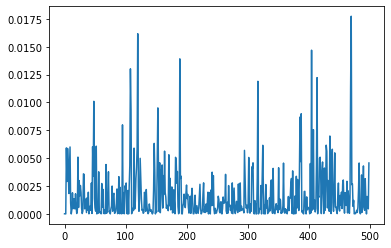

In [151]:
import matplotlib.pyplot as plt

s = sim(np.asarray([1e-3, 0.2, 0.2]), 1, 1, 500)
plt.plot(s)

In [163]:
from functools import partial

s = sim(np.asarray([1e-1, 0.2, 0.7]), 1, 1, 1000)
l = partial(_garch_nll, p=1, q=1, sq=s)
dl = partial(_garch_nll_scores, p=1, q=1, sq=s)

bhhh(l, dl, clamp=partial(np.clip, a_min=0, a_max=1), x=np.asarray([0.1, 0.1, 0.1]))

array([0.12207627, 0.20321693, 0.65666867])

Doesn't work for small values of omega. Unsure if I can use barrier method to constrain because of BHHH assumptions about the scores.